In [1]:
!pip -q install numpy scipy torch matplotlib scikit-fem[all]


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# Shapes noted inline; tested on Python 3.10+

import os, math, time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional: scikit-fem for H1-smoothness penalty
try:
    import skfem as fem
    from skfem.helpers import dot, grad
    HAVE_SKFEM = True
except Exception:
    HAVE_SKFEM = False

torch.set_float32_matmul_precision('high') if hasattr(torch, "set_float32_matmul_precision") else None

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [3]:
# x-grid shape: (N,)
# y-true shape: (N,)

def sample_curve(N: int, rng: np.random.Generator) -> tuple[np.ndarray, np.ndarray]:
    """
    y(x) = A * s(2π f x + φ); s ∈ {sin, cos}, A ∈ [0.8,1.2], f ∈ {1,2,3}, φ ∼ U[0,2π)
    """
    x = np.linspace(0.0, 1.0, N, dtype=np.float32)
    A   = rng.uniform(0.8, 1.2)
    f   = rng.choice([1, 2, 3])
    phi = rng.uniform(0.0, 2*np.pi)
    if rng.random() < 0.5:
        y = A * np.sin(2*np.pi*f*x + phi)
    else:
        y = A * np.cos(2*np.pi*f*x + phi)
    return x, y.astype(np.float32)

def gappy_sample(y: np.ndarray, M: int, sigma: float, rng: np.random.Generator):
    """
    Choose M observed indices; add N(0, σ^2) to those entries.
    Returns:
      y_obs_masked: (N,)   (unobserved entries zero-filled)
      mask:         (N,)   {0,1}
      obs_idx:      (M,)
    """
    N = y.shape[0]
    obs_idx = rng.choice(N, size=M, replace=False)
    mask = np.zeros(N, dtype=np.float32)
    mask[obs_idx] = 1.0
    y_obs = y.copy()
    y_obs[obs_idx] = y_obs[obs_idx] + rng.normal(0.0, sigma, size=M).astype(np.float32)
    y_obs[mask == 0.0] = 0.0
    return y_obs.astype(np.float32), mask, obs_idx


In [4]:
class SineGappyDataset(Dataset):
    """
    __getitem__ returns:
      inp:   concat([y_obs_masked, mask]) ∈ R^{2N}   # shape (2N,)
      y:     full ground truth ∈ R^{N}
      mask:  {0,1}^N for observed positions ∈ R^{N}
    """
    def __init__(self, N=256, M=32, sigma=0.05, size=10000, seed=0):
        self.N, self.M, self.sigma, self.size = N, M, sigma, size
        self.rng = np.random.default_rng(seed)

    def __len__(self): return self.size

    def __getitem__(self, idx):
        x, y = sample_curve(self.N, self.rng)
        y_obs, mask, _ = gappy_sample(y, self.M, self.sigma, self.rng)
        inp = np.concatenate([y_obs, mask], axis=0).astype(np.float32)  # (2N,)
        return (
            torch.from_numpy(inp),   # (2N,)
            torch.from_numpy(y),     # (N,)
            torch.from_numpy(mask)   # (N,)
        )

# quick sanity
tmp = SineGappyDataset(N=256, M=32, sigma=0.05, size=8, seed=SEED)
inp, y, mask = tmp[0]
print("Shapes — inp:", tuple(inp.shape), "y:", tuple(y.shape), "mask:", tuple(mask.shape))


Shapes — inp: (512,) y: (256,) mask: (256,)


In [5]:
class GappyAE(nn.Module):
    def __init__(self, N: int, width: int = 256, depth: int = 3):
        super().__init__()
        D_in = 2 * N
        layers = []
        last = D_in
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, N)]
        self.net = nn.Sequential(*layers)

    def forward(self, z):  # z: (B, 2N)
        return self.net(z) # -> (B, N)

# quick param count
def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

N = 256
model = GappyAE(N=N, width=256, depth=3).to(DEVICE)
print("Trainable params:", count_params(model))


Trainable params: 328704


In [6]:
def fem_stiffness_1d(N: int):
    """
    Assemble 1D stiffness matrix K (∫ grad u · grad v) on [0,1] with P1 elements.
    Returns dense np.ndarray (N,N) or None if scikit-fem is unavailable.
    """
    if not HAVE_SKFEM:
        return None
    mesh = fem.MeshLine(np.linspace(0.0, 1.0, N))
    Vh = fem.Basis(mesh, fem.ElementLineP1())

    @fem.BilinearForm
    def a(u, v, _):
        return dot(grad(u), grad(v))

    K = a.assemble(Vh).toarray().astype(np.float32)  # (N,N)
    return K

def smoothness_loss(y_hat: torch.Tensor, K_np: np.ndarray):
    """
    y_hat: (B,N), K_np: (N,N)
    penalty = mean_b  y_hat[b]^T K y_hat[b]
    """
    if K_np is None:
        return torch.tensor(0.0, device=y_hat.device)
    K = torch.from_numpy(K_np).to(y_hat.device)
    quad = (y_hat @ K) * y_hat
    return quad.sum(dim=1).mean()

K_np = fem_stiffness_1d(N)
print("K assembled?" , K_np is not None, "; shape:" , None if K_np is None else K_np.shape)


K assembled? True ; shape: (256, 256)


In [7]:
def make_loaders(N=256, M=32, sigma=0.05, train_size=10000, val_size=1000, bs=128, seed=SEED):
    tr = SineGappyDataset(N=N, M=M, sigma=sigma, size=train_size, seed=seed)
    va = SineGappyDataset(N=N, M=M, sigma=sigma, size=val_size,   seed=seed+1)
    return (
        DataLoader(tr, batch_size=bs, shuffle=True,  drop_last=True, num_workers=0),
        DataLoader(va, batch_size=bs, shuffle=False, drop_last=False, num_workers=0),
    )

def train_gappy_ae(
    N=256, M=32, sigma=0.05, epochs=50, bs=128, lr=1e-3,
    width=256, depth=3, obs_lambda=1.0, fem_lambda=1e-4, seed=SEED,
):
    torch.manual_seed(seed)
    model = GappyAE(N=N, width=width, depth=depth).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr_loader, va_loader = make_loaders(N, M, sigma, 10000, 1000, bs, seed)
    K_local = fem_stiffness_1d(N) if fem_lambda > 0 else None

    def run_epoch(loader, train_mode: bool):
        if train_mode: model.train()
        else: model.eval()
        tot, count = 0.0, 0
        with torch.set_grad_enabled(train_mode):
            for inp, y, mask in loader:
                inp  = inp.to(DEVICE)     # (B,2N)
                y    = y.to(DEVICE)       # (B,N)
                mask = mask.to(DEVICE)    # (B,N)

                y_hat = model(inp)        # (B,N)

                # loss terms
                loss_full = nn.functional.mse_loss(y_hat, y)
                loss_obs  = nn.functional.mse_loss(y_hat*mask, y*mask)
                loss_smooth = smoothness_loss(y_hat, K_local) if K_local is not None else torch.tensor(0.0, device=DEVICE)

                loss = loss_full + obs_lambda*loss_obs + fem_lambda*loss_smooth

                if train_mode:
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    opt.step()

                tot += float(loss.detach().cpu()) * inp.size(0)
                count += inp.size(0)
        return tot / max(count, 1)

    best_val = math.inf
    t0 = time.time()
    for ep in range(1, epochs+1):
        tr = run_epoch(tr_loader, True)
        va = run_epoch(va_loader, False)
        best_val = min(best_val, va)
        if ep == 1 or ep % max(1, epochs//10) == 0:
            print(f"[ep {ep:03d}] train {tr:.6f}  val {va:.6f}  best {best_val:.6f}")
    print(f"Wall-clock: {time.time()-t0:.2f}s")

    return model

@torch.no_grad()
def demo_once(model: nn.Module, N=256, M=32, sigma=0.05, seed=SEED+999, outdir="outputs"):
    rng = np.random.default_rng(seed)
    x, y = sample_curve(N, rng)                           # (N,)
    y_obs, mask, obs_idx = gappy_sample(y, M, sigma, rng) # (N,), (N,), (M,)

    z = np.concatenate([y_obs, mask], axis=0).astype(np.float32)  # (2N,)
    z_t = torch.from_numpy(z).unsqueeze(0).to(DEVICE)             # (1,2N)
    y_hat = model(z_t).squeeze(0).detach().cpu().numpy()          # (N,)

    mse = float(np.mean((y_hat - y)**2))
    psnr = 10.0 * np.log10(1.0 / max(mse, 1e-12))  # signals ~ O(1)
    print(f"Demo — MSE: {mse:.6e} ; PSNR: {psnr:.2f} dB ; N={N}, M={M}, σ={sigma}")

    os.makedirs(outdir, exist_ok=True)
    plt.figure(figsize=(8,4))
    plt.plot(x, y, lw=2, label="ground truth")
    plt.scatter(x[obs_idx], y_obs[obs_idx], s=18, label="noisy obs")
    plt.plot(x, y_hat, lw=2, ls='--', label="AE recon")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.title("Gappy-AE reconstruction")
    path = os.path.join(outdir, "gappy_recon_notebook.png")
    plt.tight_layout(); plt.savefig(path, dpi=150)
    plt.show()
    print("Saved:", path)


Device: cuda
N=256, M=32, σ=0.05, epochs=50, bs=128, width=256, depth=3, λ_obs=1.0, λ_fem=0.001


[ep 001] train 0.574675  val 0.564823  best 0.564823


[ep 005] train 0.111383  val 0.102715  best 0.102715


[ep 010] train 0.080953  val 0.081080  best 0.081080


[ep 015] train 0.078042  val 0.078085  best 0.077233


[ep 020] train 0.076186  val 0.075771  best 0.075771


[ep 025] train 0.075975  val 0.077271  best 0.075259


[ep 030] train 0.076437  val 0.075304  best 0.074449


[ep 035] train 0.075147  val 0.075915  best 0.074449


[ep 040] train 0.076562  val 0.073613  best 0.072942


[ep 045] train 0.074826  val 0.075716  best 0.072942


[ep 050] train 0.074864  val 0.072806  best 0.072092
Wall-clock: 53.81s
Demo — MSE: 2.858739e-02 ; PSNR: 15.44 dB ; N=256, M=32, σ=0.05


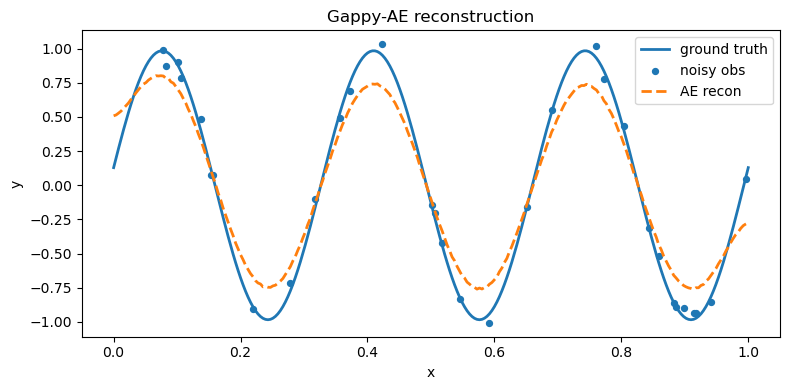

Saved: outputs/gappy_recon_notebook.png


In [8]:
# Config (edit here)
N = 256          # signal length
M = 32           # observed samples
SIGMA = 0.05     # noise std on observed entries
EPOCHS = 50
BS = 128
LR = 1e-3
WIDTH = 256
DEPTH = 3
OBS_LMB = 1.0
FEM_LMB = 1e-3   # set 0.0 to disable smoothness penalty

print("Device:", DEVICE)
print(f"N={N}, M={M}, σ={SIGMA}, epochs={EPOCHS}, bs={BS}, width={WIDTH}, depth={DEPTH}, λ_obs={OBS_LMB}, λ_fem={FEM_LMB}")

model = train_gappy_ae(
    N=N, M=M, sigma=SIGMA, epochs=EPOCHS, bs=BS, lr=LR,
    width=WIDTH, depth=DEPTH, obs_lambda=OBS_LMB, fem_lambda=FEM_LMB, seed=SEED
)

demo_once(model, N=N, M=M, sigma=SIGMA, seed=SEED+123)


Demo — MSE: 1.664359e-01 ; PSNR: 7.79 dB ; N=256, M=16, σ=0.05


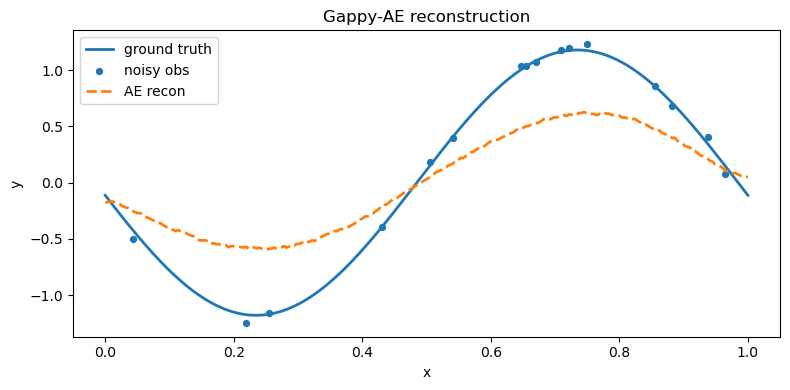

Saved: outputs/gappy_recon_notebook.png
Demo — MSE: 8.125119e-04 ; PSNR: 30.90 dB ; N=256, M=32, σ=0.1


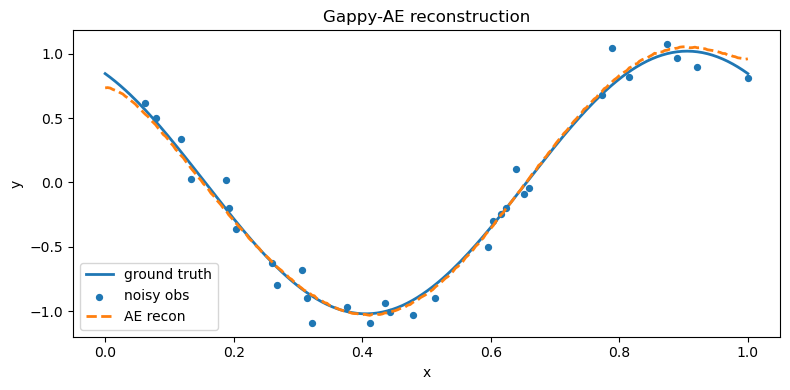

Saved: outputs/gappy_recon_notebook.png


In [9]:
# Fewer observations
demo_once(model, N=N, M=max(8, M//2), sigma=SIGMA, seed=SEED+321)

# Higher noise
demo_once(model, N=N, M=M, sigma=0.10, seed=SEED+654)


In [10]:
import math

def psnr_from_mse(mse: float) -> float:
    return 10.0 * math.log10(1.0 / max(mse, 1e-12))

def make_sampler(mask_mode="random", block_frac=0.15, cluster_k=4):
    """
    Returns a function f(y, M, sigma, rng) -> (y_obs, mask, obs_idx)
    mask_mode:
      - "random": uniform indices
      - "block": one contiguous block observed; rest zero (M ignored, use block_frac)
      - "clusters": k clusters of equal size summing to M
    """
    def sampler(y, M, sigma, rng):
        N = y.shape[0]
        if mask_mode == "random":
            obs_idx = rng.choice(N, size=M, replace=False)
        elif mask_mode == "block":
            L = max(1, int(block_frac * N))
            start = int(rng.integers(0, max(1, N - L)))
            obs_idx = np.arange(start, start + L)
            obs_idx = np.clip(obs_idx, 0, N-1)
        elif mask_mode == "clusters":
            ks = max(1, int(cluster_k))
            base = M // ks
            rem = M - ks * base
            obs_idx = []
            for i in range(ks):
                sz = base + (1 if i < rem else 0)
                if sz == 0: 
                    continue
                center = int(rng.integers(0, N))
                left = max(0, center - sz//2)
                right = min(N, left + sz)
                obs_idx.extend(range(left, right))
            obs_idx = np.array(sorted(set(np.clip(obs_idx, 0, N-1))), dtype=int)
            # adjust if we overshot
            if obs_idx.size > M:
                obs_idx = rng.choice(obs_idx, size=M, replace=False)
        else:
            raise ValueError("unknown mask_mode")
        obs_idx = np.unique(obs_idx)
        mask = np.zeros(N, dtype=np.float32)
        mask[obs_idx] = 1.0
        y_obs = y.copy()
        y_obs[obs_idx] = y_obs[obs_idx] + rng.normal(0.0, sigma, size=obs_idx.size).astype(np.float32)
        y_obs[mask == 0.0] = 0.0
        return y_obs.astype(np.float32), mask, obs_idx
    return sampler

@torch.no_grad()
def eval_batch(model, N=256, M=32, sigma=0.05, n_trials=200, mask_mode="random", seed=12345, freq_choices=(1,2,3), only_sin=False, only_cos=False):
    rng = np.random.default_rng(seed)
    sampler = make_sampler(mask_mode)
    mses = []
    for _ in range(n_trials):
        # custom curve with optional distribution shift
        x = np.linspace(0.0, 1.0, N, dtype=np.float32)
        A   = rng.uniform(0.8, 1.2)
        f   = rng.choice(freq_choices)
        phi = rng.uniform(0.0, 2*np.pi)
        if only_sin:
            y = A * np.sin(2*np.pi*f*x + phi)
        elif only_cos:
            y = A * np.cos(2*np.pi*f*x + phi)
        else:
            y = A * (np.sin(2*np.pi*f*x + phi) if rng.random() < 0.5 else np.cos(2*np.pi*f*x + phi))
        y = y.astype(np.float32)

        y_obs, mask, _ = sampler(y, M, sigma, rng)
        z = np.concatenate([y_obs, mask], axis=0).astype(np.float32)  # (2N,)
        z_t = torch.from_numpy(z).unsqueeze(0).to(DEVICE)
        y_hat = model(z_t).squeeze(0).cpu().numpy()
        mses.append(np.mean((y_hat - y)**2))
    mses = np.array(mses)
    return float(mses.mean()), float(mses.std()), float(psnr_from_mse(mses.mean()))


σ=0.000  MSE=1.517e-02  PSNR=18.19 dB


σ=0.025  MSE=1.517e-02  PSNR=18.19 dB


σ=0.050  MSE=1.525e-02  PSNR=18.17 dB


σ=0.075  MSE=1.540e-02  PSNR=18.13 dB


σ=0.100  MSE=1.562e-02  PSNR=18.06 dB


σ=0.125  MSE=1.591e-02  PSNR=17.98 dB


σ=0.150  MSE=1.628e-02  PSNR=17.88 dB


σ=0.175  MSE=1.673e-02  PSNR=17.76 dB


σ=0.200  MSE=1.726e-02  PSNR=17.63 dB


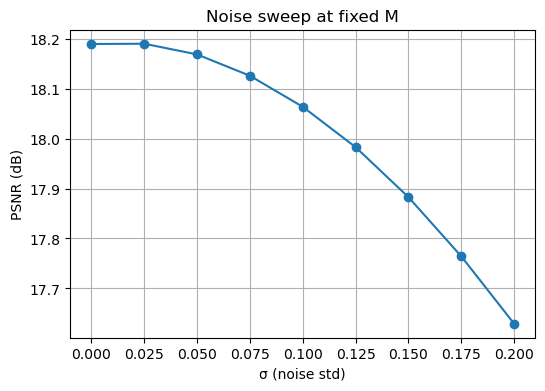

In [11]:
sigmas = np.linspace(0.0, 0.20, 9)
psnrs = []
for s in sigmas:
    mse_mean, mse_std, psnr = eval_batch(model, N=N, M=M, sigma=float(s), n_trials=400, mask_mode="random", seed=SEED+77)
    psnrs.append(psnr)
    print(f"σ={s:.3f}  MSE={mse_mean:.3e}  PSNR={psnr:.2f} dB")

plt.figure(figsize=(6,4))
plt.plot(sigmas, psnrs, marker='o')
plt.xlabel("σ (noise std)"); plt.ylabel("PSNR (dB)")
plt.title("Noise sweep at fixed M")
plt.grid(True); plt.show()


M=  4  MSE=4.385e-01  PSNR=3.58 dB
M= 17  MSE=1.474e-01  PSNR=8.32 dB


M= 31  MSE=1.943e-02  PSNR=17.11 dB
M= 45  MSE=3.869e-02  PSNR=14.12 dB


M= 59  MSE=1.953e-01  PSNR=7.09 dB
M= 72  MSE=4.867e-01  PSNR=3.13 dB


M= 86  MSE=9.500e-01  PSNR=0.22 dB
M=100  MSE=1.512e+00  PSNR=-1.80 dB


M=114  MSE=2.258e+00  PSNR=-3.54 dB
M=128  MSE=3.191e+00  PSNR=-5.04 dB


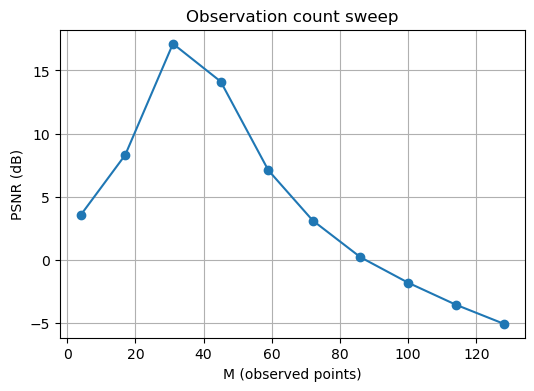

In [12]:
Ms = np.unique(np.linspace(4, N//2, 10, dtype=int))
psnrs = []
for m in Ms:
    mse_mean, mse_std, psnr = eval_batch(model, N=N, M=int(m), sigma=SIGMA, n_trials=400, mask_mode="random", seed=SEED+88)
    psnrs.append(psnr)
    print(f"M={m:3d}  MSE={mse_mean:.3e}  PSNR={psnr:.2f} dB")

plt.figure(figsize=(6,4))
plt.plot(Ms, psnrs, marker='o')
plt.xlabel("M (observed points)"); plt.ylabel("PSNR (dB)")
plt.title("Observation count sweep")
plt.grid(True); plt.show()


random     MSE=1.395e-02  PSNR=18.55 dB
block      MSE=3.877e-01  PSNR=4.11 dB


clusters   MSE=1.901e-01  PSNR=7.21 dB


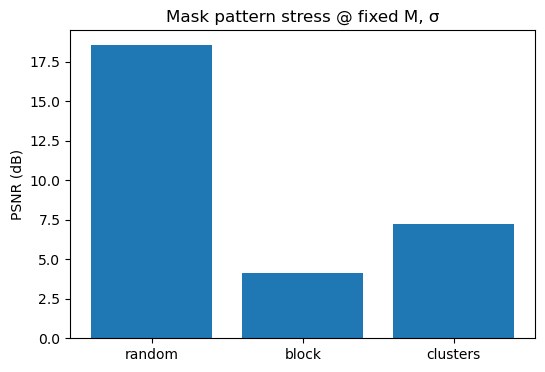

In [13]:
modes = ["random", "block", "clusters"]
scores = []
for mode in modes:
    mse_mean, mse_std, psnr = eval_batch(model, N=N, M=M, sigma=SIGMA, n_trials=400, mask_mode=mode, seed=SEED+99)
    scores.append((mode, mse_mean, psnr))
    print(f"{mode:9s}  MSE={mse_mean:.3e}  PSNR={psnr:.2f} dB")

plt.figure(figsize=(6,4))
plt.bar([s[0] for s in scores], [s[2] for s in scores])
plt.ylabel("PSNR (dB)"); plt.title("Mask pattern stress @ fixed M, σ")
plt.show()


In [14]:
def train_on_only_sin(N=256, M=32, sigma=0.05, epochs=20, bs=128, lr=1e-3, width=256, depth=3, obs_lambda=1.0, fem_lambda=FEM_LMB, seed=SEED):
    # dataset wrapper forcing sin at train time
    class SinOnly(SineGappyDataset):
        def __getitem__(self, idx):
            x = np.linspace(0.0, 1.0, self.N, dtype=np.float32)
            A   = self.rng.uniform(0.8, 1.2)
            f   = self.rng.choice([1,2,3])
            phi = self.rng.uniform(0.0, 2*np.pi)
            y = (A * np.sin(2*np.pi*f*x + phi)).astype(np.float32)
            y_obs, mask, _ = gappy_sample(y, self.M, self.sigma, self.rng)
            inp = np.concatenate([y_obs, mask], axis=0).astype(np.float32)
            return torch.from_numpy(inp), torch.from_numpy(y), torch.from_numpy(mask)

    torch.manual_seed(seed)
    model = GappyAE(N=N, width=width, depth=depth).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr = DataLoader(SinOnly(N,M,sigma,8000,seed), batch_size=bs, shuffle=True, drop_last=True)
    va = DataLoader(SinOnly(N,M,sigma,1000,seed+1), batch_size=bs, shuffle=False)
    K_local = fem_stiffness_1d(N) if fem_lambda > 0 else None

    def run_epoch(loader, train_mode):
        if train_mode: model.train()
        else: model.eval()
        tot, cnt = 0.0, 0
        with torch.set_grad_enabled(train_mode):
            for inp, y, mask in loader:
                inp, y, mask = inp.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
                y_hat = model(inp)
                loss = (nn.functional.mse_loss(y_hat, y)
                        + obs_lambda*nn.functional.mse_loss(y_hat*mask, y*mask)
                        + (fem_lambda*smoothness_loss(y_hat, K_local) if K_local is not None else 0.0))
                if train_mode:
                    opt.zero_grad(set_to_none=True)
                    loss.backward(); opt.step()
                tot += float(loss.detach().cpu()) * inp.size(0); cnt += inp.size(0)
        return tot/max(cnt,1)

    for ep in range(1, epochs+1):
        trl = run_epoch(tr, True)
        val = run_epoch(va, False)
        if ep==1 or ep%5==0:
            print(f"[ep {ep:02d}] train {trl:.5f}  val {val:.5f}")
    return model

# train on sin-only (few epochs), test on cos-only
model_sin = train_on_only_sin(N=N, M=M, sigma=SIGMA, epochs=20, bs=BS, lr=LR, width=WIDTH, depth=DEPTH)
mse_mean, mse_std, psnr = eval_batch(model_sin, N=N, M=M, sigma=SIGMA, n_trials=500, mask_mode="random",
                                     seed=SEED+2024, freq_choices=(1,2,3), only_cos=True)
print(f"Sin-trained → Cos-test:  MSE={mse_mean:.3e}  PSNR={psnr:.2f} dB")


[ep 01] train 0.58042  val 0.57159


[ep 05] train 0.16456  val 0.16816


[ep 10] train 0.08777  val 0.08549


[ep 15] train 0.08138  val 0.08145


[ep 20] train 0.07931  val 0.08196
Sin-trained → Cos-test:  MSE=1.693e-02  PSNR=17.71 dB


f=1  PSNR=26.11 dB
f=2  PSNR=19.74 dB


f=3  PSNR=14.97 dB
f=4  PSNR=2.46 dB


f=5  PSNR=2.48 dB
f=6  PSNR=2.46 dB


f=7  PSNR=2.47 dB
f=8  PSNR=2.46 dB


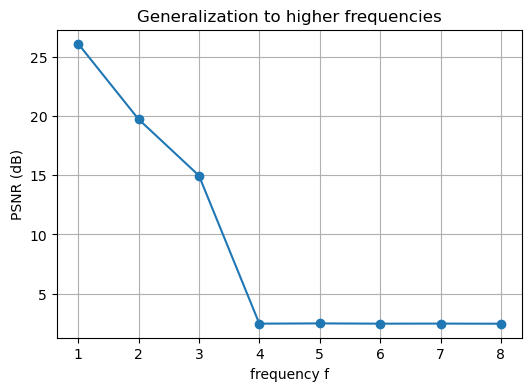

In [15]:
freq_grid = [1,2,3,4,5,6,7,8]
psnrs_f = []
for f in freq_grid:
    mse_mean, mse_std, psnr = eval_batch(model, N=N, M=M, sigma=SIGMA, n_trials=300,
                                         mask_mode="random", seed=SEED+222, freq_choices=(f,))
    psnrs_f.append(psnr)
    print(f"f={f}  PSNR={psnr:.2f} dB")

plt.figure(figsize=(6,4))
plt.plot(freq_grid, psnrs_f, marker='o')
plt.xlabel("frequency f"); plt.ylabel("PSNR (dB)")
plt.title("Generalization to higher frequencies")
plt.grid(True); plt.show()



=== λ_FEM=0.0 ===


[ep 001] train 0.204899  val 0.061624  best 0.061624


[ep 002] train 0.050905  val 0.043263  best 0.043263


[ep 003] train 0.036463  val 0.029086  best 0.029086


[ep 004] train 0.023596  val 0.017519  best 0.017519


[ep 005] train 0.013795  val 0.009817  best 0.009817


[ep 006] train 0.007984  val 0.006573  best 0.006573


[ep 007] train 0.005416  val 0.004720  best 0.004720


[ep 008] train 0.004153  val 0.003716  best 0.003716


[ep 009] train 0.003628  val 0.003612  best 0.003612


[ep 010] train 0.003127  val 0.003197  best 0.003197


[ep 011] train 0.002860  val 0.002918  best 0.002918


[ep 012] train 0.002692  val 0.002552  best 0.002552


[ep 013] train 0.002549  val 0.002319  best 0.002319


[ep 014] train 0.002435  val 0.002272  best 0.002272


[ep 015] train 0.002274  val 0.002184  best 0.002184
Wall-clock: 16.30s
λ_FEM=0.0 → PSNR=27.06 dB

=== λ_FEM=0.0001 ===


[ep 001] train 0.303584  val 0.077069  best 0.077069


[ep 002] train 0.066880  val 0.056085  best 0.056085


[ep 003] train 0.046828  val 0.038709  best 0.038709


[ep 004] train 0.031229  val 0.024832  best 0.024832


[ep 005] train 0.021071  val 0.018182  best 0.018182


[ep 006] train 0.016792  val 0.014920  best 0.014920


[ep 007] train 0.014922  val 0.014453  best 0.014453


[ep 008] train 0.013880  val 0.013561  best 0.013561


[ep 009] train 0.013286  val 0.013051  best 0.013051


[ep 010] train 0.013115  val 0.012693  best 0.012693


[ep 011] train 0.012649  val 0.012483  best 0.012483


[ep 012] train 0.012399  val 0.012342  best 0.012342


[ep 013] train 0.012150  val 0.012085  best 0.012085


[ep 014] train 0.012119  val 0.011969  best 0.011969


[ep 015] train 0.011811  val 0.011711  best 0.011711
Wall-clock: 16.14s
λ_FEM=0.0001 → PSNR=26.42 dB

=== λ_FEM=0.001 ===


[ep 001] train 0.579688  val 0.567977  best 0.567977


[ep 002] train 0.437591  val 0.295696  best 0.295696


[ep 003] train 0.199554  val 0.140661  best 0.140661


[ep 004] train 0.121611  val 0.113495  best 0.113495


[ep 005] train 0.108188  val 0.101688  best 0.101688


[ep 006] train 0.098276  val 0.093179  best 0.093179


[ep 007] train 0.090120  val 0.087791  best 0.087791


[ep 008] train 0.085100  val 0.082310  best 0.082310


[ep 009] train 0.082232  val 0.080071  best 0.080071


[ep 010] train 0.080850  val 0.078311  best 0.078311


[ep 011] train 0.079666  val 0.077724  best 0.077724


[ep 012] train 0.079628  val 0.084235  best 0.077724


[ep 013] train 0.078425  val 0.078103  best 0.077724


[ep 014] train 0.078121  val 0.075628  best 0.075628


[ep 015] train 0.079046  val 0.079778  best 0.075628
Wall-clock: 16.29s
λ_FEM=0.001 → PSNR=17.97 dB

=== λ_FEM=0.01 ===


[ep 001] train 0.669764  val 0.579581  best 0.579581


[ep 002] train 0.571782  val 0.581403  best 0.579581


[ep 003] train 0.570241  val 0.573314  best 0.573314


[ep 004] train 0.571199  val 0.566868  best 0.566868


[ep 005] train 0.569370  val 0.563423  best 0.563423


[ep 006] train 0.550144  val 0.535091  best 0.535091


[ep 007] train 0.524880  val 0.520629  best 0.520629


[ep 008] train 0.519162  val 0.516425  best 0.516425


[ep 009] train 0.513760  val 0.512600  best 0.512600


[ep 010] train 0.509480  val 0.509276  best 0.509276


[ep 011] train 0.506551  val 0.491908  best 0.491908


[ep 012] train 0.498800  val 0.490389  best 0.490389


[ep 013] train 0.480737  val 0.468123  best 0.468123


[ep 014] train 0.460697  val 0.448269  best 0.448269


[ep 015] train 0.452974  val 0.448327  best 0.448269
Wall-clock: 16.06s
λ_FEM=0.01 → PSNR=4.43 dB


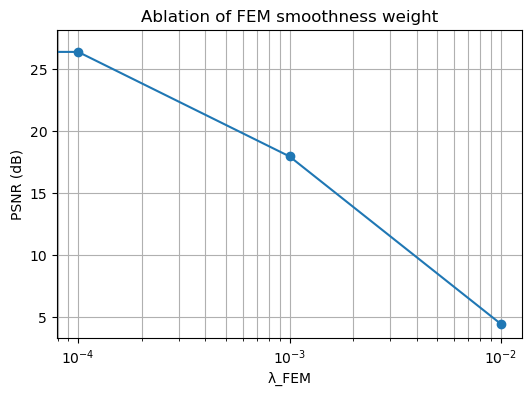

In [16]:
def quick_train_with_lambda(lmb, epochs=15):
    return train_gappy_ae(N=N, M=M, sigma=SIGMA, epochs=epochs, bs=BS, lr=LR,
                          width=WIDTH, depth=DEPTH, obs_lambda=OBS_LMB, fem_lambda=lmb, seed=SEED+int(1e5*lmb)%100000)

lambdas = [0.0, 1e-4, 1e-3, 1e-2]
psnrs_l = []
for lmb in lambdas:
    print(f"\n=== λ_FEM={lmb} ===")
    m_l = quick_train_with_lambda(lmb, epochs=15)
    mse_mean, mse_std, psnr = eval_batch(m_l, N=N, M=M, sigma=SIGMA, n_trials=400, mask_mode="random", seed=SEED+303)
    psnrs_l.append(psnr)
    print(f"λ_FEM={lmb} → PSNR={psnr:.2f} dB")

plt.figure(figsize=(6,4))
plt.plot(lambdas, psnrs_l, marker='o')
plt.xscale('log'); plt.xlabel("λ_FEM"); plt.ylabel("PSNR (dB)")
plt.title("Ablation of FEM smoothness weight")
plt.grid(True, which="both"); plt.show()
